In [173]:
import os

import torch
from glob import glob
from scipy import ndimage
import math
import json
import numpy as np

import cv2
from matplotlib import pyplot as plt
import matplotlib

from pathlib import Path
from math import sin, cos
from dotenv import load_dotenv

from YOLO.util import get_teeth_ROI
from edge.util import tooth_isolation, gum_jaw_separation, vertical_separation, bounding_teeth_on_origin
from preprocess.util import recovery_rotated_bounding, xyxy2xywh, get_image_by_labels, get_labels_by_image
from preprocess.util import xyxy_reformat, rotate_bounding_boxes, rect_include_another

matplotlib.use('module://matplotlib_inline.backend_inline')
load_dotenv()


True

In [174]:
target_labels = ['caries', 'endo', 'post', 'crown']
image_labels_df = get_image_by_labels(target_labels)[target_labels]

image_labels_df


,caries,endo,post,crown
filename,,,,
00006145,True,False,False,False
00008026,True,True,True,True
00008113,True,True,True,True
00008117,True,False,False,False
00008131,True,True,False,False
...,...,...,...,...
202012050412159442018_0690727A,False,True,True,True
202012050412229432017_0781002A,False,True,False,False
202012051012069362000_0760503A,False,True,False,True


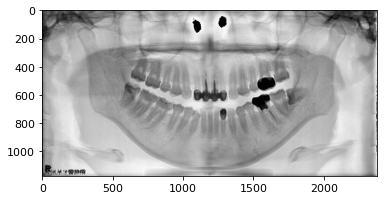

In [175]:
data_dir = '..' / Path(os.getenv('DATASET_DIR'))

filename = image_labels_df.index[1]
filepath_image = data_dir / f'{filename}.jpg'
filepath_json = data_dir / f'{filename}.json'

im_0 = cv2.imread(filepath_image)
plt.imshow(1 - im_0)
plt.show()


# Demo rotation

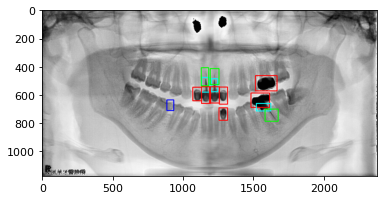

In [176]:
# TODO draw annotation bounding box
labels = get_labels_by_image(filepath_json, target_labels)
colors_dict = {target_labels[i - 1]: [int(j) * 255 for j in bin(i)[2:].zfill(3)] for i in
               range(1, len(target_labels) + 1)}

im_annotated = 1 - im_0.copy()

for label in labels:
    xyxy = np.array([np.hstack(label['points'])]).astype(int)
    xyxy = xyxy_reformat(xyxy)[0]
    color = colors_dict[label['label']]

    im_annotated = cv2.rectangle(im_annotated, xyxy[:2], xyxy[2:], color, thickness=5)

plt.imshow(im_annotated)
plt.show()


In [192]:
model = torch.hub.load(r'..\YOLO', 'custom', path=r'..\YOLO\weights\8-bound.pt', source='local')
# Image
# Inference
results = model(filepath_image)

teeth_roi = get_teeth_ROI(results)
teeth_roi_images = teeth_roi['images'][filename]
teeth_roi_split_teeth = teeth_roi['split_teeth']
teeth_roi_split_teeth


YOLOv5  torch 1.10.0+cpu CPU

Fusing layers... 
Model summary: 270 layers, 7041205 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


requirements: C:\Users\denni\anaconda3\envs\dentist-cv\Lib\site-packages\yolov5\requirements.txt not found, check failed.


{'00008026': {'37': {'xyxy': [tensor(1599.56836),
    tensor(553.74554),
    tensor(1774.64587),
    tensor(764.09552)]},
  '47': {'xyxy': [tensor(620.81128),
    tensor(562.39362),
    tensor(831.92377),
    tensor(771.31873)]},
  '27': {'xyxy': [tensor(1641.94067),
    tensor(294.77347),
    tensor(1767.99390),
    tensor(519.10883)]},
  '13': {'xyxy': [tensor(975.40637),
    tensor(337.80295),
    tensor(1067.84753),
    tensor(640.76141)]},
  '17': {'xyxy': [tensor(617.78455),
    tensor(281.41547),
    tensor(748.13098),
    tensor(528.62476)]},
  '33': {'xyxy': [tensor(1306.57263),
    tensor(683.74091),
    tensor(1389.30798),
    tensor(928.54401)]},
  '43': {'xyxy': [tensor(1023.43896),
    tensor(694.71973),
    tensor(1133.38708),
    tensor(926.29749)]},
  '23': {'xyxy': [tensor(1314.82642),
    tensor(352.16986),
    tensor(1398.47559),
    tensor(643.06104)]}}}

In [178]:
tooth_position_dict = {
    0: 'left',
    1: 'middle',
    2: 'right'
}

target_roi = teeth_roi_images[3]
target_roi_image = target_roi['image']
flag = target_roi['flag']
tooth_position = tooth_position_dict[target_roi['number']]
im_g = cv2.cvtColor(target_roi_image, cv2.COLOR_RGBA2GRAY)

isolation_data = tooth_isolation(im_g, flag=flag, tooth_position=tooth_position, rotation_fix=False)
regions = isolation_data['crop_regions']
theta = isolation_data['angle']
offset = target_roi['offset']

regions


{46: {'xyxy': array([ 64, 123, 188, 494], dtype=int64)},
 45: {'xyxy': array([188, 123, 273, 494], dtype=int64)},
 44: {'xyxy': array([273, 123, 332, 494], dtype=int64)}}

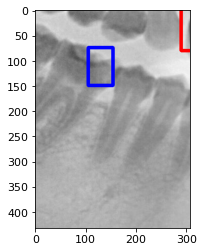

In [179]:
target_roi_image_annotated = 1 - target_roi_image.copy()

for label in labels:
    xyxy = np.hstack(label['points'])
    xyxy = xyxy - np.tile(offset, 2)
    xyxy = xyxy.astype(int)
    xywh = xyxy2xywh(np.array([xyxy])).astype(int)[0]
    color = colors_dict[label['label']]

    target_roi_image_annotated = cv2.rectangle(target_roi_image_annotated, xyxy[:2], xyxy[2:], color, thickness=5)

plt.imshow(target_roi_image_annotated)
plt.show()


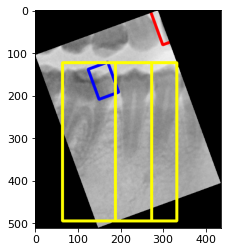

{46: {'xyxy': array([ 64, 123, 188, 494], dtype=int64)},
 45: {'xyxy': array([188, 123, 273, 494], dtype=int64)},
 44: {'xyxy': array([273, 123, 332, 494], dtype=int64)}}

In [180]:
image_roi_rotated = ndimage.rotate(target_roi_image_annotated, theta)

image_roi_rotated_teeth = image_roi_rotated.copy()
for tooth_number, data in regions.items():
    xyxy = data['xyxy']
    image_roi_rotated_teeth = cv2.rectangle(image_roi_rotated_teeth, xyxy[:2], xyxy[2:], (255, 255, 0), thickness=5)

plt.imshow(image_roi_rotated_teeth)
plt.show()
regions


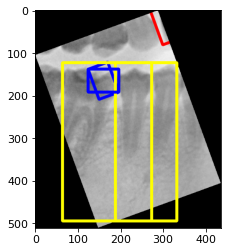

In [181]:
phi = math.radians(theta)
im_g_shape = np.array(np.array(im_g.shape)[[1, 0]])
image_roi_rotated_teeth_annotated = image_roi_rotated_teeth.copy()
labels_rotated = []
for label in labels:
    xyxy = np.hstack(label['points'])  # [x, y, x, y]
    xyxy = xyxy_reformat(np.array([xyxy]))

    xyxy = xyxy - np.tile(offset, 2)
    xyxy = rotate_bounding_boxes(phi, im_g_shape, xyxy)

    color = colors_dict[label['label']]
    xyxy = xyxy[0].astype(int)

    if xyxy.min() < 0 or np.any(xyxy[2:] > im_g_shape[[1, 0]]):
        continue

    labels_rotated.append(xyxy)
    image_roi_rotated_teeth_annotated = cv2.rectangle(image_roi_rotated_teeth_annotated, xyxy[:2], xyxy[2:], color,
                                                      thickness=5)

plt.imshow(image_roi_rotated_teeth_annotated)
plt.show()

# xyxy[[1, 3]]


In [182]:
image_labels = {}

for label in labels:
    xyxy = np.hstack(label['points'])  # [x, y, x, y]
    xyxy = xyxy_reformat(np.array([xyxy]))

    xyxy = xyxy - np.tile(offset, 2)
    if xyxy.min() < 0:
        continue

    xyxy = rotate_bounding_boxes(phi, im_g_shape, xyxy)
    xyxy = xyxy[0].astype(int)

    for tooth_number, region in regions.items():
        tooth_xyxy = region['xyxy']
        if rect_include_another(tooth_xyxy, xyxy) > 0.5:
            key = f'{filename}-{tooth_number}'
            if not key in image_labels.keys():
                image_labels[key] = []
            image_labels[key].append(label['label'])

image_labels


{'00008026-46': ['caries']}